##  Loading all dependencies
Here we load all the libraries we will need for our first regression problem.

In [8]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: torchmetrics in c:\users\sri vatsa\appdata\local\programs\python\python312\lib\site-packages (1.5.1)




[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split


In [10]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

# 1  Linear regression 

## 1.1  Linear model 

### 1.1.1 Data generation
Here we generate some artificial data using a linear function and adding some noise to it.


In [11]:
def f_linear(x, m, b):
    return m * x + b

In [12]:
# number of points
npoints = 500

# noise parameter
dmax = 1

# interval
min_val = 0
max_val = 9

# slope and offset
m = 2.0
b = 5.00


In [13]:
# generate data 
x = np.linspace(min_val, max_val, npoints)
y = f_linear(x, m, b) + np.random.randn(npoints) * dmax
y_orig = f_linear(x, m, b)

# make the data two-dimensional (expected by the model)
x = x.reshape(-1,1)
y = y.reshape(-1,1)
y_orig = y_orig.reshape(-1,1)

Let's plot the data and have a look!

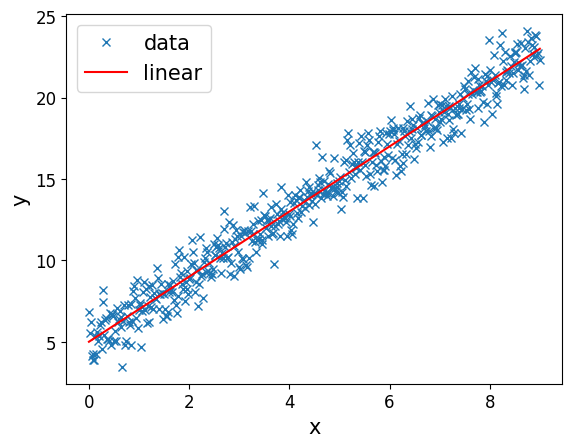

In [14]:
plt.plot(x,y, 'x', label = 'data')
plt.plot(x,y_orig,  label = 'linear',c="red")
plt.legend(fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



### 1.1.2  Datasets and DataLoaders


In [15]:
class Data(Dataset):
  """Dataset wrapper. Takes numpy arrays and stores them as torch tensors.
    Data is transformed to the device."""
  def __init__(self, x: np.ndarray,
                y: np.ndarray,
                device: str = DEVICE):
    self.x = torch.from_numpy(x).float().to(device)
    self.y =  torch.from_numpy(y).float().to(device)
    self.len = self.x.shape[0]
  
  def __getitem__(self, index: int) -> tuple:
    return self.x[index].float(), self.y[index].float()
  
  def __len__(self) -> int:
    return self.len

Now let's divide the full dataset into two smaller datasets for training and validation

In [16]:
# define fraction of data used for training
train_fraction = .8
n_train = int(train_fraction * npoints)

# get indices for training and test set
ids = np.arange(npoints)
np.random.shuffle(ids)
ids_train, ids_test  = np.split(ids, [n_train])

# generate datasets for training and testing        
train_data = Data(x[ids_train], y[ids_train])
test_data = Data(x[ids_test], y[ids_test])

In [17]:
print("The length of train data is:",len(train_data))
print("The length of test data is:",len(test_data))

The length of train data is: 400
The length of test data is: 100


In [18]:
batch_size = 16  #samples(here 16) to be processed in each iteration.
trainloader = DataLoader(train_data, 
                         batch_size=batch_size, 
                         shuffle=True)
testloader = DataLoader(test_data, 
                         batch_size=batch_size, 
                         shuffle=True)

Let's plot training and validation data!

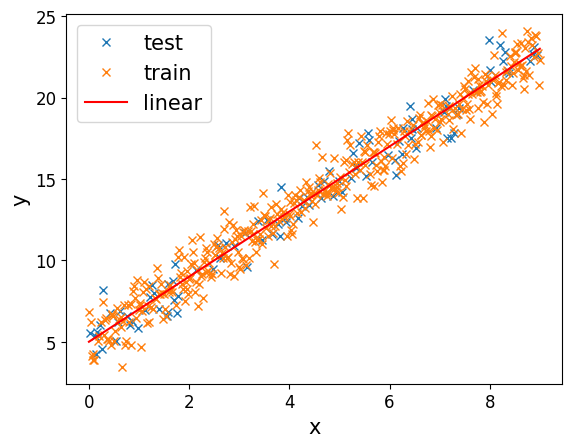

In [19]:
plt.plot(test_data.x,test_data.y, 'x', label = 'test')
plt.plot(train_data.x,train_data.y, 'x', label = 'train')
plt.plot(x, y_orig,  label = 'linear',c="red")
plt.legend(fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



### 1.1.3  Building and training a model

In [20]:
# fit the data with a linear regression model:
# y(w,x) = b + w1*x1 + w2*x2 + ... + wp*xp
# here we only fit b and w1, since we have 1D data
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(in_features=1,
                                      out_features=1,bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out

In [21]:
learningRate = 0.01 
n_epochs = 100

# generate a model and move it to the device
model = LinearRegression().to(DEVICE)

We can print the model to get some information.

In [22]:
print(model)

LinearRegression(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


Let's see how the untrained model performs!

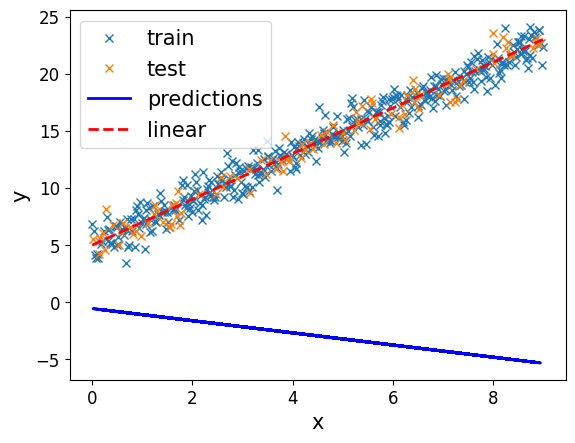

In [23]:
# Get model predictions for the test set
# we disable gradients because we are not in training mode here
# and get problems with numpy functions (used in the plotting routines)
with torch.no_grad():
    y_pred_test = model(test_data.x)

plt.plot(train_data.x ,train_data.y, 'x', label = 'train')
plt.plot(test_data.x, test_data.y, 'x', label = 'test')

# Plot the predicted data 
plt.plot(test_data.x, y_pred_test,c="blue", label = 'predictions',linewidth=2)
plt.plot(x,y_orig,  label = 'linear',c="red",linestyle="dashed",linewidth=2)
plt.legend(fontsize=15)

plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



In [24]:
print('R2 score = %8.5f' % r2_score(y_pred_test, test_data.y))


R2 score = -9.84903


In [25]:
# criterion to computes the loss between input and target
criterion = nn.MSELoss()

# optimizer that will be used to update weights and biases
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

This is how a standard training loop in pytorch looks like.

In [26]:
n_epochs = 1000
losses = np.empty(n_epochs)
n_log = 50

for epoch in range(n_epochs):
  running_loss = 0.0
  for i, (inputs, labels) in enumerate(trainloader):
    outputs = model(inputs)
    
    # compute loss
    loss = criterion(outputs, labels)   
    
    # set optimizer to zero grad to remove previous gradients
    optimizer.zero_grad()    # backward propagation
    
    # get gradients
    loss.backward()

    # gradient descent
    optimizer.step() 
    
    losses[epoch] = loss.item() # store loss

  if epoch % n_log == 0:
    print(f'Epochs:{epoch :5d} | ' \
          f'Loss: {loss :.10f}')

Epochs:    0 | Loss: 5.3949661255
Epochs:   50 | Loss: 1.1172219515
Epochs:  100 | Loss: 0.2533974946
Epochs:  150 | Loss: 0.5672284961
Epochs:  200 | Loss: 0.9305056930
Epochs:  250 | Loss: 1.1701349020
Epochs:  300 | Loss: 0.4627659619
Epochs:  350 | Loss: 1.4574095011
Epochs:  400 | Loss: 1.5075037479
Epochs:  450 | Loss: 1.4388891459
Epochs:  500 | Loss: 0.8192726970
Epochs:  550 | Loss: 0.8386409283
Epochs:  600 | Loss: 0.4409275651
Epochs:  650 | Loss: 0.3298768103
Epochs:  700 | Loss: 0.6654740572
Epochs:  750 | Loss: 0.5182747841
Epochs:  800 | Loss: 1.1431504488
Epochs:  850 | Loss: 0.9154803753
Epochs:  900 | Loss: 1.8128924370
Epochs:  950 | Loss: 0.9635505676


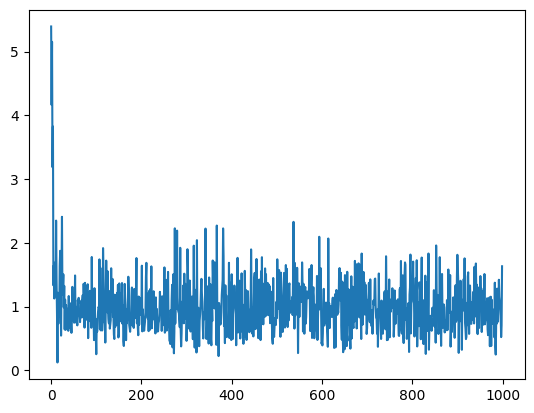

In [27]:
plt.plot(losses)
plt.show()

### 1.1.4  Model evaluation


In [28]:
# get predictions for training and test set
with torch.no_grad():
    y_pred_train = model(train_data.x)
    y_pred_test = model(test_data.x)


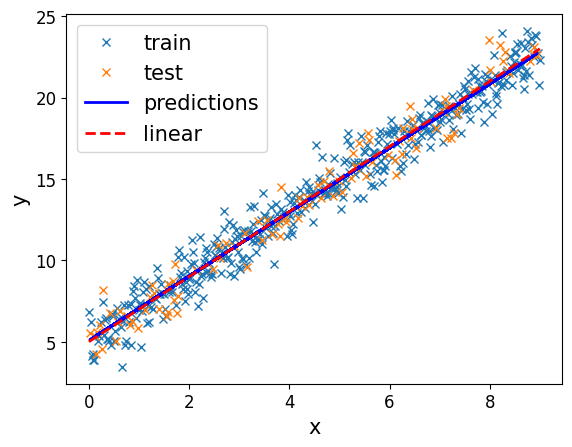

In [29]:
plt.plot(train_data.x ,train_data.y, 'x', label = 'train')
plt.plot(test_data.x, test_data.y, 'x', label = 'test')

# Plot the predicted data 
plt.plot(test_data.x, y_pred_test,c="blue", label = 'predictions',linewidth=2)
plt.plot(x,y_orig,  label = 'linear',c="red",linestyle="dashed",linewidth=2)
plt.legend(fontsize=15)

plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



In [30]:
mse_test = mean_squared_error(test_data.y,y_pred_test)
mse_train = mean_squared_error(train_data.y,y_pred_train)

mae_test = mean_absolute_error(test_data.y,y_pred_test)
mae_train = mean_absolute_error(train_data.y,y_pred_train)

print('MSE test  = %8.4f    MAE test  = %8.4f' % (mse_test,mae_test))
print('MSE train = %8.4f    MAE train = %8.4f' % (mse_train,mae_train))

MSE test  =   0.8715    MAE test  =   0.7207
MSE train =   0.9571    MAE train =   0.7747


In [31]:
print('R2 score = %8.5f' % r2_score(y_pred_test, test_data.y))


R2 score =  0.97036


Let's see what the parameters the model has learned. 

In [32]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print("Learned m:", layer.state_dict()['weight'])
        print("Learned b:", layer.state_dict()['bias'])
print("Exact m:", m)
print("Exact b:",b)

Learned m: tensor([[1.9702]])
Learned b: tensor([5.0857])
Exact m: 2.0
Exact b: 5.0


The learned parameters are quite close to the ones we used for generating the data!

## 1.2 Experiments

### 1.2.1 Different datasets


Fitting model for dmax = 1

Epochs:     0 | Loss: 4.0521306992
Epochs:    50 | Loss: 1.9259237051
Epochs:   100 | Loss: 1.0993090868
Epochs:   150 | Loss: 1.0382921696
Epochs:   200 | Loss: 0.7575696707
Epochs:   250 | Loss: 0.8342462778
Epochs:   300 | Loss: 0.8714349270
Epochs:   350 | Loss: 1.8665901423
Epochs:   400 | Loss: 0.9787003398
Epochs:   450 | Loss: 0.8712954521
Epochs:   500 | Loss: 1.4533041716
Epochs:   550 | Loss: 1.2513978481
Epochs:   600 | Loss: 1.3645180464
Epochs:   650 | Loss: 1.0916452408
Epochs:   700 | Loss: 1.3059860468
Epochs:   750 | Loss: 0.6045332551
Epochs:   800 | Loss: 0.7186965942
Epochs:   850 | Loss: 0.6371602416
Epochs:   900 | Loss: 0.7870527506
Epochs:   950 | Loss: 2.3558666706


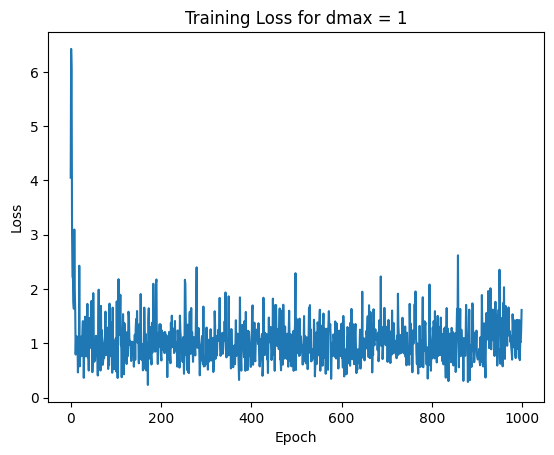


dmax = 1:
MSE test  = 0.8835    MAE test  = 0.7466
MSE train = 1.0203    MAE train = 0.7977
R2 score = 0.96980
Learned m: 1.9332
Learned b: 5.2125
Exact m: 2.0, Exact b: 5.0

Fitting model for dmax = 10

Epochs:     0 | Loss: 132.4617614746
Epochs:    50 | Loss: 83.2322158813
Epochs:   100 | Loss: 82.6789550781
Epochs:   150 | Loss: 191.2794342041
Epochs:   200 | Loss: 117.2872467041
Epochs:   250 | Loss: 127.2858657837
Epochs:   300 | Loss: 111.3818664551
Epochs:   350 | Loss: 111.7125091553
Epochs:   400 | Loss: 108.0311126709
Epochs:   450 | Loss: 122.7663040161
Epochs:   500 | Loss: 65.6634521484
Epochs:   550 | Loss: 102.2134628296
Epochs:   600 | Loss: 123.4975509644
Epochs:   650 | Loss: 127.6646347046
Epochs:   700 | Loss: 219.9393615723
Epochs:   750 | Loss: 102.5258026123
Epochs:   800 | Loss: 168.7048797607
Epochs:   850 | Loss: 95.2530822754
Epochs:   900 | Loss: 81.9363708496
Epochs:   950 | Loss: 87.6121368408


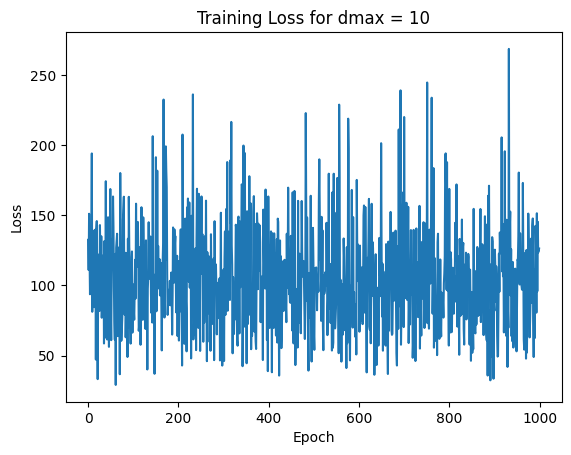


dmax = 10:
MSE test  = 124.9859    MAE test  = 8.9321
MSE train = 101.8458    MAE train = 8.0911
R2 score = 0.10914
Learned m: 2.1351
Learned b: 3.5324
Exact m: 2.0, Exact b: 5.0

Fitting model for dmax = 20

Epochs:     0 | Loss: 597.8179931641
Epochs:    50 | Loss: 585.8483886719
Epochs:   100 | Loss: 610.3646850586
Epochs:   150 | Loss: 567.7163696289
Epochs:   200 | Loss: 408.2078857422
Epochs:   250 | Loss: 619.4652099609
Epochs:   300 | Loss: 567.7751464844
Epochs:   350 | Loss: 673.8401489258
Epochs:   400 | Loss: 650.7804565430
Epochs:   450 | Loss: 452.4064941406
Epochs:   500 | Loss: 409.4187622070
Epochs:   550 | Loss: 301.3556213379
Epochs:   600 | Loss: 406.2297058105
Epochs:   650 | Loss: 580.2536621094
Epochs:   700 | Loss: 459.7804870605
Epochs:   750 | Loss: 463.6141052246
Epochs:   800 | Loss: 209.9741973877
Epochs:   850 | Loss: 275.6345520020
Epochs:   900 | Loss: 558.9411010742
Epochs:   950 | Loss: 384.1008911133


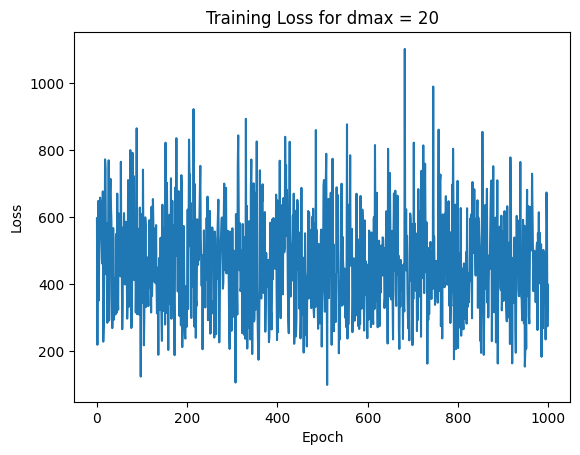


dmax = 20:
MSE test  = 345.0151    MAE test  = 14.8335
MSE train = 450.6686    MAE train = 16.9358
R2 score = 0.01154
Learned m: 1.4020
Learned b: 7.7161
Exact m: 2.0, Exact b: 5.0


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Linear function definition
def f_linear(x, m, b):
    return m * x + b

# Parameters
npoints = 500
min_val, max_val = 0, 9
m, b = 2.0, 5.0
train_fraction = 0.8
batch_size = 16
learning_rate = 0.01
n_epochs = 1000
n_log = 50

# Dataset wrapper class
class Data(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, device: str = DEVICE):
        self.x = torch.from_numpy(x).float().to(device)
        self.y = torch.from_numpy(y).float().to(device)
        self.len = self.x.shape[0]
  
    def __getitem__(self, index: int) -> tuple:
        return self.x[index], self.y[index]
  
    def __len__(self) -> int:
        return self.len

# Linear regression model
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(in_features=1, out_features=1, bias=True)

    def forward(self, x):
        return self.linear(x)

# Main function for generating data, training, and evaluating the model
def train_and_evaluate(dmax):
    print(f"\nFitting model for dmax = {dmax}\n")

    # Generate data with noise
    x = np.linspace(min_val, max_val, npoints).reshape(-1, 1)
    y = f_linear(x, m, b) + np.random.randn(npoints, 1) * dmax
    y_orig = f_linear(x, m, b).reshape(-1, 1)

    # Split the data into training and test sets
    n_train = int(train_fraction * npoints)
    ids = np.arange(npoints)
    np.random.shuffle(ids)
    ids_train, ids_test = np.split(ids, [n_train])

    # Prepare datasets and loaders
    train_data = Data(x[ids_train], y[ids_train])
    test_data = Data(x[ids_test], y[ids_test])
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Model, loss function, and optimizer
    model = LinearRegression().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Training loop
    losses = []
    for epoch in range(n_epochs):
        for inputs, labels in trainloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        
        # Log progress
        if epoch % n_log == 0:
            print(f'Epochs: {epoch :5d} | Loss: {loss :.10f}')

    # Plot the loss over epochs
    plt.plot(losses)
    plt.title(f"Training Loss for dmax = {dmax}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Evaluate model
    with torch.no_grad():
        y_pred_train = model(train_data.x)
        y_pred_test = model(test_data.x)

    # Calculate metrics
    mse_test = mean_squared_error(test_data.y, y_pred_test)
    mse_train = mean_squared_error(train_data.y, y_pred_train)
    mae_test = mean_absolute_error(test_data.y, y_pred_test)
    mae_train = mean_absolute_error(train_data.y, y_pred_train)
    r2 = r2_score(y_pred_test, test_data.y)

    print(f"\ndmax = {dmax}:")
    print(f"MSE test  = {mse_test:.4f}    MAE test  = {mae_test:.4f}")
    print(f"MSE train = {mse_train:.4f}    MAE train = {mae_train:.4f}")
    print(f"R2 score = {r2:.5f}")

    # Display learned parameters
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            learned_m = layer.state_dict()['weight'].item()
            learned_b = layer.state_dict()['bias'].item()
            print(f"Learned m: {learned_m:.4f}")
            print(f"Learned b: {learned_b:.4f}")
    print(f"Exact m: {m}, Exact b: {b}")

# Run experiments for each dmax value
for d in [1, 10, 20]:
    train_and_evaluate(d)


### Qn) How do the values change as a function of dmax? Explain the observed trend.

### Soln) As we change the d_max values:
#### -MSE,MAE values will increase due to higher noise levels, as in plots.
#### -R^2 is expected to increase as noise increases.

### 1.2.2 Create a dataset for high_val =50 or 100 and smaller learning_rate then train the model. 


Fitting model for dmax = 1

Epochs:     0 | Loss: 30.7202777863
Epochs:    50 | Loss: 3.2511174679
Epochs:   100 | Loss: 1.0206459761
Epochs:   150 | Loss: 1.0175344944
Epochs:   200 | Loss: 1.0279372931
Epochs:   250 | Loss: 0.8602584600
Epochs:   300 | Loss: 0.4249620438
Epochs:   350 | Loss: 1.1830897331
Epochs:   400 | Loss: 0.9446178079
Epochs:   450 | Loss: 0.8689180613
Epochs:   500 | Loss: 1.1961554289
Epochs:   550 | Loss: 1.3954621553
Epochs:   600 | Loss: 0.8743490577
Epochs:   650 | Loss: 0.9849827886
Epochs:   700 | Loss: 1.8408031464
Epochs:   750 | Loss: 1.6292170286
Epochs:   800 | Loss: 1.0751892328
Epochs:   850 | Loss: 1.1131500006
Epochs:   900 | Loss: 1.2121347189
Epochs:   950 | Loss: 1.2479828596
Epochs:  1000 | Loss: 1.1359659433
Epochs:  1050 | Loss: 0.6236658692
Epochs:  1100 | Loss: 0.6617743969
Epochs:  1150 | Loss: 0.3064918220
Epochs:  1200 | Loss: 0.2391422093
Epochs:  1250 | Loss: 1.1924902201
Epochs:  1300 | Loss: 0.9199432135
Epochs:  1350 | Loss: 1.0

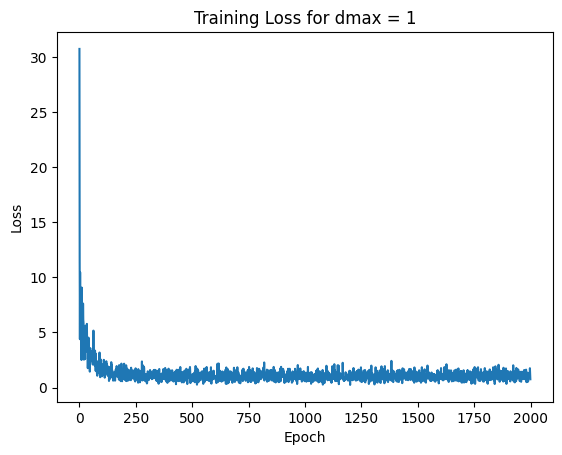


dmax = 1:
MSE test  = 1.0502    MAE test  = 0.7822
MSE train = 1.0315    MAE train = 0.8140
R2 score = 0.96672
Learned m: 2.0180
Learned b: 4.9337
Exact m: 2.0, Exact b: 5.0

Fitting model for dmax = 10

Epochs:     0 | Loss: 87.3073272705
Epochs:    50 | Loss: 108.2527847290
Epochs:   100 | Loss: 120.2760620117
Epochs:   150 | Loss: 91.1884841919
Epochs:   200 | Loss: 114.3580627441
Epochs:   250 | Loss: 66.7606735229
Epochs:   300 | Loss: 39.7938842773
Epochs:   350 | Loss: 125.3327789307
Epochs:   400 | Loss: 178.2959594727
Epochs:   450 | Loss: 196.9211730957
Epochs:   500 | Loss: 152.5609741211
Epochs:   550 | Loss: 86.3035430908
Epochs:   600 | Loss: 63.9772872925
Epochs:   650 | Loss: 100.3397369385
Epochs:   700 | Loss: 82.9069519043
Epochs:   750 | Loss: 137.3771362305
Epochs:   800 | Loss: 118.7610473633
Epochs:   850 | Loss: 134.2247009277
Epochs:   900 | Loss: 93.1699905396
Epochs:   950 | Loss: 86.6919937134
Epochs:  1000 | Loss: 91.9220428467
Epochs:  1050 | Loss: 115.36

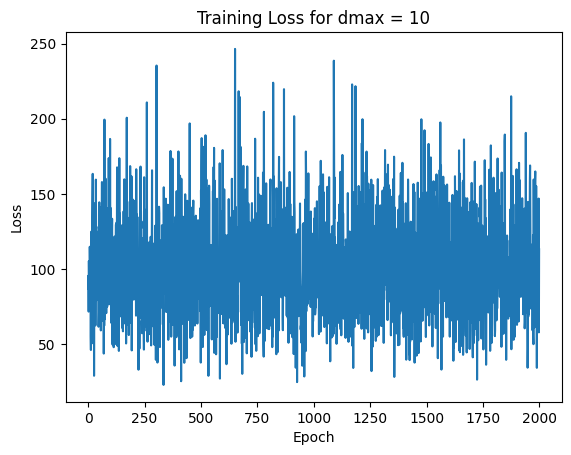


dmax = 10:
MSE test  = 107.4956    MAE test  = 8.4195
MSE train = 101.5254    MAE train = 8.0631
R2 score = 0.14084
Learned m: 1.9770
Learned b: 4.2794
Exact m: 2.0, Exact b: 5.0

Fitting model for dmax = 20

Epochs:     0 | Loss: 431.6989440918
Epochs:    50 | Loss: 193.4098052979
Epochs:   100 | Loss: 437.6022033691
Epochs:   150 | Loss: 797.8081665039
Epochs:   200 | Loss: 457.7867736816
Epochs:   250 | Loss: 431.7554016113
Epochs:   300 | Loss: 196.2961425781
Epochs:   350 | Loss: 263.2910766602
Epochs:   400 | Loss: 390.2572021484
Epochs:   450 | Loss: 347.6124572754
Epochs:   500 | Loss: 253.3893737793
Epochs:   550 | Loss: 225.5672607422
Epochs:   600 | Loss: 303.3239746094
Epochs:   650 | Loss: 599.6491088867
Epochs:   700 | Loss: 314.0362548828
Epochs:   750 | Loss: 575.8150634766
Epochs:   800 | Loss: 529.1748657227
Epochs:   850 | Loss: 307.4754333496
Epochs:   900 | Loss: 254.3442687988
Epochs:   950 | Loss: 386.2454833984
Epochs:  1000 | Loss: 358.5515441895
Epochs:  1050

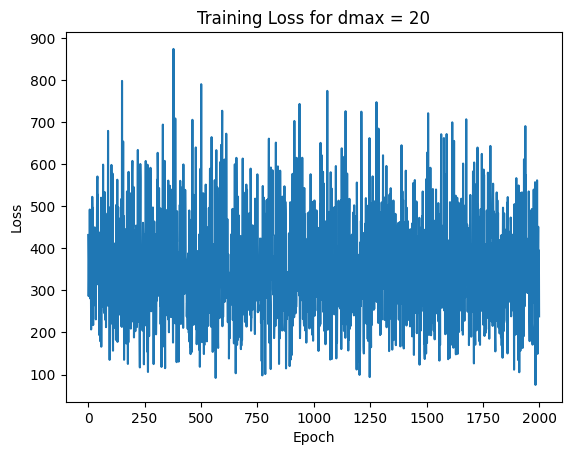


dmax = 20:
MSE test  = 420.4892    MAE test  = 14.8748
MSE train = 355.9392    MAE train = 14.9037
R2 score = 0.05708
Learned m: 2.0535
Learned b: 4.3818
Exact m: 2.0, Exact b: 5.0


In [47]:
# Updated parameters for larger interval
high_val = 100  # Use a larger interval instead of 50
learning_rate = 0.001  # Smaller learning rate instead of 0.1
n_epochs = 2000  # Increase epochs to ensure convergence
train_fraction = 0.8

n_log = 50
batch_size = 16
min_val, max_val = 0, 9
m, b = 2.0, 5.0
npoints = 500

# Update data generation with larger interval
def train_and_evaluate(dmax):
    print(f"\nFitting model for dmax = {dmax}, interval = [{min_val}, {high_val}]\n")
    
    # Generate data over larger interval with noise
    x = np.linspace(min_val, high_val, npoints).reshape(-1, 1)
    y = f_linear(x, m, b) + np.random.randn(npoints, 1) * dmax

    # Optionally apply scaling (normalization)
    x = (x - x.mean()) / x.std()  # standardization
    y = (y - y.mean()) / y.std() 

# Check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Linear function definition
def f_linear(x, m, b):
    return m * x + b

# Dataset wrapper class
class Data(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, device: str = DEVICE):
        self.x = torch.from_numpy(x).float().to(device)
        self.y = torch.from_numpy(y).float().to(device)
        self.len = self.x.shape[0]
  
    def __getitem__(self, index: int) -> tuple:
        return self.x[index], self.y[index]
  
    def __len__(self) -> int:
        return self.len

# Linear regression model
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(in_features=1, out_features=1, bias=True)

    def forward(self, x):
        return self.linear(x)

# Main function for generating data, training, and evaluating the model
def train_and_evaluate(dmax):
    print(f"\nFitting model for dmax = {dmax}\n")

    # Generate data with noise
    x = np.linspace(min_val, max_val, npoints).reshape(-1, 1)
    y = f_linear(x, m, b) + np.random.randn(npoints, 1) * dmax
    y_orig = f_linear(x, m, b).reshape(-1, 1)

    # Split the data into training and test sets
    n_train = int(train_fraction * npoints)
    ids = np.arange(npoints)
    np.random.shuffle(ids)
    ids_train, ids_test = np.split(ids, [n_train])

    # Prepare datasets and loaders
    train_data = Data(x[ids_train], y[ids_train])
    test_data = Data(x[ids_test], y[ids_test])
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Model, loss function, and optimizer
    model = LinearRegression().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Training loop
    losses = []
    for epoch in range(n_epochs):
        for inputs, labels in trainloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        
        # Log progress
        if epoch % n_log == 0:
            print(f'Epochs: {epoch :5d} | Loss: {loss :.10f}')

    # Plot the loss over epochs
    plt.plot(losses)
    plt.title(f"Training Loss for dmax = {dmax}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Evaluate model
    with torch.no_grad():
        y_pred_train = model(train_data.x)
        y_pred_test = model(test_data.x)

    # Calculate metrics
    mse_test = mean_squared_error(test_data.y, y_pred_test)
    mse_train = mean_squared_error(train_data.y, y_pred_train)
    mae_test = mean_absolute_error(test_data.y, y_pred_test)
    mae_train = mean_absolute_error(train_data.y, y_pred_train)
    r2 = r2_score(y_pred_test, test_data.y)

    print(f"\ndmax = {dmax}:")
    print(f"MSE test  = {mse_test:.4f}    MAE test  = {mae_test:.4f}")
    print(f"MSE train = {mse_train:.4f}    MAE train = {mae_train:.4f}")
    print(f"R2 score = {r2:.5f}")

    # Display learned parameters
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            learned_m = layer.state_dict()['weight'].item()
            learned_b = layer.state_dict()['bias'].item()
            print(f"Learned m: {learned_m:.4f}")
            print(f"Learned b: {learned_b:.4f}")
    print(f"Exact m: {m}, Exact b: {b}")

# Run experiments for each dmax value
for d in [1, 10, 20]:
    train_and_evaluate(d)



#### Observations of using large interval and small learning rate
1. model takes longer to converge (with minimising loss function over time) or may not converge for higher interval
2. Loss increases drastically from plots.
3. R^2 value is lower with increasing intervals.
4. Unscaled data leads to unstable training.
5. Lots of noise influence with larger d_max

### 1.2.2 Scaled data

### min-max scaling class using PTMinMaxScaler()

In [48]:
class PTMinMaxScaler(object):
    """"Scaler class for min-max scaling."""
    def __init__(self, tensor, new_max, new_min):
        self.v_min, self.v_max = tensor.min(), tensor.max()
        self.new_max, self.new_min = new_max, new_min

    def scale(self, tensor):
        return (tensor - self.v_min)/(self.v_max - self.v_min)*(self.new_max - self.new_min) + self.new_min

    def inverse_scale(self, tensor):
        return (tensor - self.new_min) * (self.v_max - self.v_min)/(self.new_max - self.new_min) + self.v_min


In [50]:
# example usage of scaler class
x = np.linspace(-1,2, 5)

# fit the scaler
x_scaler = PTMinMaxScaler(x, 1. , 0.)
x_scaled = x_scaler.scale(x)

print(x,"\n", x_scaled,"\n", x_scaler.inverse_scale(x_scaled))

## PTMinMaxScaler for scaling data before training the model
*(Tried working out but there seems some error as learned m,b are way off to m,b actual in my code!)*

In [52]:
# Check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Linear function definition
def f_linear(x, m, b):
    return m * x + b

# Parameters
npoints = 500
min_val, high_val = 0, 100  # Larger interval
m, b = 2.0, 5.0
train_fraction = 0.8
batch_size = 16
learning_rate = 0.001  # Smaller learning rate
n_epochs = 2000  # Increase epochs for convergence
n_log = 50

In [53]:
# Dataset wrapper class
class Data(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, device: str = DEVICE):
        self.x = torch.from_numpy(x).float().to(device)
        self.y = torch.from_numpy(y).float().to(device)
        self.len = self.x.shape[0]
  
    def __getitem__(self, index: int) -> tuple:
        return self.x[index], self.y[index]
  
    def __len__(self) -> int:
        return self.len
    
# Linear regression model
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(in_features=1, out_features=1, bias=True)

    def forward(self, x):
        return self.linear(x)

In [54]:
# Scaler class for min-max scaling using PTMinMaxScaler(object)
class PTMinMaxScaler(object):
    """Scaler class for min-max scaling."""
    def __init__(self, tensor, new_max, new_min):
        self.v_min, self.v_max = tensor.min(), tensor.max()
        self.new_max, self.new_min = new_max, new_min

    def scale(self, tensor):
        return (tensor - self.v_min) / (self.v_max - self.v_min) * (self.new_max - self.new_min) + self.new_min

    def inverse_scale(self, tensor):
        return (tensor - self.new_min) * (self.v_max - self.v_min) / (self.new_max - self.new_min) + self.v_min


Fitting model for dmax = 1, interval = [0, 100]

Epochs:     0 | Loss: 0.0736552477
Epochs:    50 | Loss: 0.0420298763
Epochs:   100 | Loss: 0.0233576093
Epochs:   150 | Loss: 0.0242669918
Epochs:   200 | Loss: 0.0115721421
Epochs:   250 | Loss: 0.0092897955
Epochs:   300 | Loss: 0.0073465100
Epochs:   350 | Loss: 0.0036042533
Epochs:   400 | Loss: 0.0032691814
Epochs:   450 | Loss: 0.0027004532
Epochs:   500 | Loss: 0.0021020439
Epochs:   550 | Loss: 0.0012147339
Epochs:   600 | Loss: 0.0008958880
Epochs:   650 | Loss: 0.0006340801
Epochs:   700 | Loss: 0.0003416775
Epochs:   750 | Loss: 0.0004336026
Epochs:   800 | Loss: 0.0003191489
Epochs:   850 | Loss: 0.0000699551
Epochs:   900 | Loss: 0.0001197133
Epochs:   950 | Loss: 0.0001060167
Epochs:  1000 | Loss: 0.0000689272
Epochs:  1050 | Loss: 0.0000360226
Epochs:  1100 | Loss: 0.0000717528
Epochs:  1150 | Loss: 0.0000678136
Epochs:  1200 | Loss: 0.0000574454
Epochs:  1250 | Loss: 0.0000203714
Epochs:  1300 | Loss: 0.0000340055
Epoch

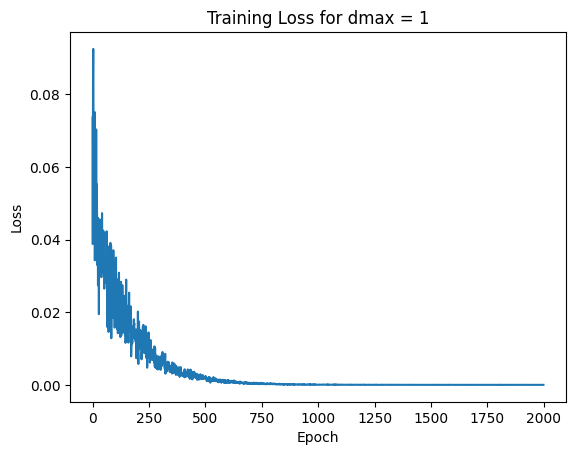


dmax = 1:
MSE test  = 13771.7109    MAE test  = 102.9516
MSE train = 14356.2090    MAE train = 104.9920
R2 score = -171301.28125
Learned m: 0.9986
Learned b: 0.0006
Exact m: 2.0, Exact b: 5.0

Fitting model for dmax = 10, interval = [0, 100]

Epochs:     0 | Loss: 0.3064118624
Epochs:    50 | Loss: 0.0644687563
Epochs:   100 | Loss: 0.0605468526
Epochs:   150 | Loss: 0.0188912302
Epochs:   200 | Loss: 0.0421243198
Epochs:   250 | Loss: 0.0135269212
Epochs:   300 | Loss: 0.0190257728
Epochs:   350 | Loss: 0.0075785904
Epochs:   400 | Loss: 0.0061849477
Epochs:   450 | Loss: 0.0064161569
Epochs:   500 | Loss: 0.0020952872
Epochs:   550 | Loss: 0.0038173336
Epochs:   600 | Loss: 0.0033265478
Epochs:   650 | Loss: 0.0033676419
Epochs:   700 | Loss: 0.0032294586
Epochs:   750 | Loss: 0.0027891917
Epochs:   800 | Loss: 0.0022544765
Epochs:   850 | Loss: 0.0015389035
Epochs:   900 | Loss: 0.0029818399
Epochs:   950 | Loss: 0.0021573938
Epochs:  1000 | Loss: 0.0006292643
Epochs:  1050 | Loss:

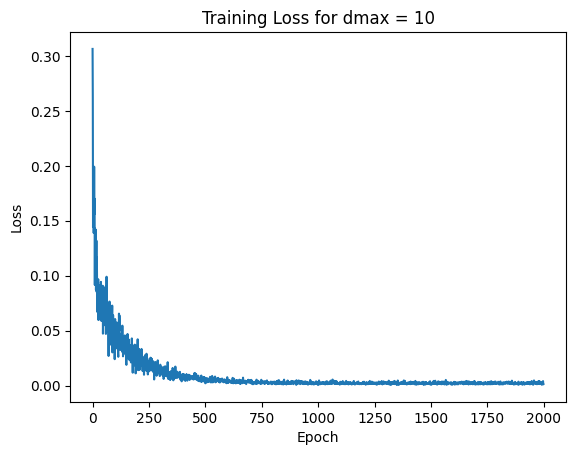


dmax = 10:
MSE test  = 16394.6680    MAE test  = 113.6737
MSE train = 13862.9775    MAE train = 102.7891
R2 score = -233617.10938
Learned m: 0.9221
Learned b: 0.0426
Exact m: 2.0, Exact b: 5.0

Fitting model for dmax = 20, interval = [0, 100]

Epochs:     0 | Loss: 2.2209630013
Epochs:    50 | Loss: 0.0127174417
Epochs:   100 | Loss: 0.0101419389
Epochs:   150 | Loss: 0.0081440350
Epochs:   200 | Loss: 0.0021246732
Epochs:   250 | Loss: 0.0051870933
Epochs:   300 | Loss: 0.0115071014
Epochs:   350 | Loss: 0.0076093711
Epochs:   400 | Loss: 0.0050369008
Epochs:   450 | Loss: 0.0036205389
Epochs:   500 | Loss: 0.0029605953
Epochs:   550 | Loss: 0.0076332251
Epochs:   600 | Loss: 0.0045145173
Epochs:   650 | Loss: 0.0068503027
Epochs:   700 | Loss: 0.0035547423
Epochs:   750 | Loss: 0.0090182200
Epochs:   800 | Loss: 0.0064269053
Epochs:   850 | Loss: 0.0067202323
Epochs:   900 | Loss: 0.0034025179
Epochs:   950 | Loss: 0.0050271205
Epochs:  1000 | Loss: 0.0059973029
Epochs:  1050 | Loss

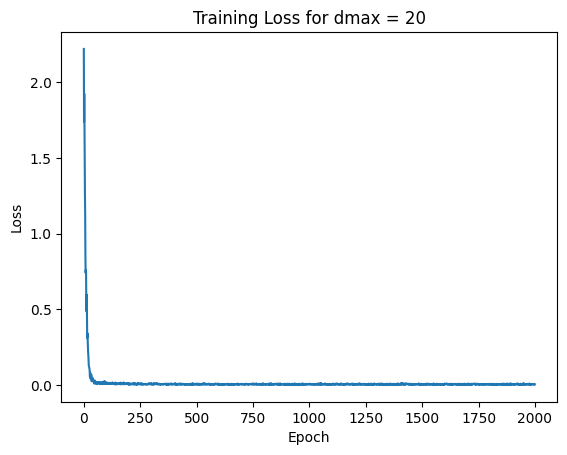


dmax = 20:
MSE test  = 13454.9111    MAE test  = 100.6503
MSE train = 14492.1250    MAE train = 105.1967
R2 score = -268984.75000
Learned m: 0.7377
Learned b: 0.1582
Exact m: 2.0, Exact b: 5.0


In [55]:
# Main function for generating data, training, and evaluating the model
#using prev codes
def train_and_evaluate(dmax):
    print(f"\nFitting model for dmax = {dmax}, interval = [{min_val}, {high_val}]\n")
    
    # Generate data over larger interval with noise
    x = np.linspace(min_val, high_val, npoints).reshape(-1, 1)
    y = f_linear(x, m, b) + np.random.randn(npoints, 1) * dmax

    # Scale data
    x_scaler = PTMinMaxScaler(torch.from_numpy(x), 1.0, 0.0)
    y_scaler = PTMinMaxScaler(torch.from_numpy(y), 1.0, 0.0)
    x_scaled = x_scaler.scale(torch.from_numpy(x))
    y_scaled = y_scaler.scale(torch.from_numpy(y))

    # Split the data into training and test sets
    n_train = int(train_fraction * npoints)
    ids = np.arange(npoints)
    np.random.shuffle(ids)
    ids_train, ids_test = np.split(ids, [n_train])

    # Prepare datasets and loaders
    train_data = Data(x_scaled[ids_train].numpy(), y_scaled[ids_train].numpy())
    test_data = Data(x_scaled[ids_test].numpy(), y_scaled[ids_test].numpy())
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # Model, loss function, and optimizer
    model = LinearRegression().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Training loop
    losses = []
    for epoch in range(n_epochs):
        for inputs, labels in trainloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        
        # Log progress
        if epoch % n_log == 0:
            print(f'Epochs: {epoch :5d} | Loss: {loss :.10f}')

    # Plot the loss over epochs
    plt.plot(losses)
    plt.title(f"Training Loss for dmax = {dmax}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Evaluate model
    with torch.no_grad():
        y_pred_train = model(train_data.x)
        y_pred_test = model(test_data.x)

    # Inverse scale predictions
    y_pred_train_original = y_scaler.inverse_scale(y_pred_train)
    y_pred_test_original = y_scaler.inverse_scale(y_pred_test)

    # Calculate metrics
    mse_test = mean_squared_error(test_data.y, y_pred_test_original)
    mse_train = mean_squared_error(train_data.y, y_pred_train_original)
    mae_test = mean_absolute_error(test_data.y, y_pred_test_original)
    mae_train = mean_absolute_error(train_data.y, y_pred_train_original)
    r2 = r2_score(y_pred_test_original, test_data.y)

    print(f"\ndmax = {dmax}:")
    print(f"MSE test  = {mse_test:.4f}    MAE test  = {mae_test:.4f}")
    print(f"MSE train = {mse_train:.4f}    MAE train = {mae_train:.4f}")
    print(f"R2 score = {r2:.5f}")

    # Display learned parameters
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            learned_m = layer.state_dict()['weight'].item()
            learned_b = layer.state_dict()['bias'].item()
            print(f"Learned m: {learned_m:.4f}")
            print(f"Learned b: {learned_b:.4f}")
    print(f"Exact m: {m}, Exact b: {b}")

# Run experiments for each dmax value
for d in [1, 10, 20]:
    train_and_evaluate(d)
